# Data Processing Version 4 - Updated Feb 8, 2023
1. Read Files
2. Segment Selection - select target TMC & XD segments for input and output
3. Processing for Input Features and Output Ground Truth
    - Raw Speed
    - Speed Feature Processing (TTI & SD)
    - Incident Processing
        - Mark as Incident based on (1) Waze & RCRS report and (2) slow down speed
        - Mark as Incident based on Abnormal Speed
        - For output ground truth, mark as incident based on upstream abnormal speed.
    - Density Processing
    - Miscellaneous (weather, time)
    - Concat Input Features Together and Normalize

### Key Differences from Data Preprocessing Version 1, 2 & 3
- Based on the updated geoprocessing in (1) TMC-XD matching and (2) upstream segments, the target segements selected here are different.
- Dedicated TTI & SD processing rather than loading from Old X
- Updated input features and output ground truth arrangement


In [1]:
import csv
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import pickle

from datetime import datetime as dt
from collections import Counter
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils import *

In [2]:
pwd

'/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/pipeline_v2/data_processing'

In [3]:
cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/pipeline_v2


In [4]:
# Hyper-parameters during Data Processing 

# Dates and Timewindows that we are interested in 
start_date = dt(2019, 2, 10)
end_date = dt(2019, 7, 23)
start_min = 330 # 05:30:00 
end_min = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 117, note that the end_date here is inclusive 
all_date = pd.date_range(start=start_date, end=end_date).date # 164 dates, note that the end_date here is inclusive 
busi_idx = [i for i, b in enumerate(all_date) if b in busi_date]

# For Segment Selection
para_na_rate_spd_quantile_threshold_tmc_all = 0.5
para_na_rate_spd_quantile_threshold_xd = 1

# For incident processing
para_in_inc_spd_quantile_threshold = 0.15
para_out_inc_spd_quantile_threshold = 0.15
para_out_inc_space_limit = 5 # how far we are tracing upstream (5 miles here)
para_out_inc_tti_threshold = 1.6 # how slow the speed is compared with its reference speed (1.6 here)
para_out_inc_lead_time = 30 # how long we are marking in advance (30 min here)

## Part 1. Read Files

### 1.1 Old X

In [188]:
'''
Dates of old X & old Y: 2019.2.10 ~ 2019.7.23 (164 days, including all holidays & weekends)
Time Slots: 
    - For each day, there are 180 targeted time slots from 06:00:00 to 20:55:00
    - For each targeted time slot t (t in 06:00:00 ~ 20:55:00), 
        - old_Y contains padding of 7 slots (t-6, t-5, t-4, t-3, t-2, t-1, t)
        - old_X contains padding of 7 slots as input (t-12, t-11, t-10, t-9, t-8, t-7, t-6)
    
    In new_X and new Y, to allow for more flexibility of hyperparameters and reduce the file size, there won't be padding
    For example, for targeted time slot 06:00:00
        - old_Y has 05:30:00, 05:35:00, 05:40:00, 05:45:00, 05:50:00, 05:55:00, 06:00:00
        - old_X has 05:00:00, 05:05:00, 05:10:00, 05:15:00, 05:20:00, 05:25:00, 05:30:00
        - new_Y has 06:00:00
        - new_X has 05:30:00
'''
old_X = np.load("../data/old/old_X.npy")  # (29520, 7, 1008)
# old_Y = np.load("../data/old/old_Y.npy")  # (29520, 7, 162)
old_col = list(np.load("../data/old/old_col.npy", allow_pickle=True))  # 1008 (369 tti, 315 inc, 303 sd, 21 weather & time)

FileNotFoundError: [Errno 2] No such file or directory: '../data/old/old_X.npy'

### 1.2 TMC Speed Data and TMC Segments

In [5]:
# 2. TMC Speed Data and TMC Segments
'''
Columns:
    'tmc_code', 'measurement_tstamp', 'speed', 'average_speed',
    'reference_speed', 'travel_time_minutes', 'data_density'
'''
df_raw_spd_tmc_truck = pd.read_csv("../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average/manually_select_cranberry_2019_dont_average.csv") # 1173 tmc (9136192, 7)
df_raw_spd_tmc_pv = pd.read_csv("../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_3/manually_select_cranberry_2019_dont_average.csv")  # 1188 tmc (21385940, 7)
df_raw_spd_tmc_all = pd.read_csv("../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_2/manually_select_cranberry_2019_dont_average.csv") # 1189 tmc (24388983,7)

# '''
# Columns:
#     'tmc', 'road', 'direction', 'intersection', 'state', 'county', 'zip',
#     'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
#     'miles', 'road_order', 'timezone_name', 'type', 'country', 'tmclinear',
#     'frc', 'border_set', 'f_system', 'urban_code', 'faciltype', 'structype',
#     'thrulanes', 'route_numb', 'route_sign', 'route_qual', 'altrtename',
#     'aadt', 'aadt_singl', 'aadt_combi', 'nhs', 'nhs_pct', 'strhnt_typ',
#     'strhnt_pct', 'truck', 'isprimary', 'active_start_date',
#     'active_end_date'
# '''
df_tmc_attr = pd.read_csv("../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_2/TMC_Identification.csv")  # (1248, 39), this is the comprehensive list, TMC speed csv data (All/Truck/PV) DOES NOT include all TMC in this list

In [6]:
# Speed of All Vehicles in All 1189 Segments => Useful for imputation on XD speed data
df_spd_tmc_all_1189 = df_raw_spd_tmc_all[["tmc_code", "measurement_tstamp", "speed"]]
df_spd_tmc_all_1189 = df_spd_tmc_all_1189.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed")

# convert index to datetime object, and select 21762 rows of interest => shape (21762, 1189)
df_spd_tmc_all_1189.index = pd.to_datetime(df_spd_tmc_all_1189.index)
df_spd_tmc_all_1189 = df_spd_tmc_all_1189[pd.Index(df_spd_tmc_all_1189.index.date).isin(busi_date)]
df_spd_tmc_all_1189 = df_spd_tmc_all_1189[(df_spd_tmc_all_1189.index.hour * 60 + df_spd_tmc_all_1189.index.minute >= 330 ) & (df_spd_tmc_all_1189.index.hour * 60 + df_spd_tmc_all_1189.index.minute <= 1255)] # (117 * 186, 1189) covers 05:30:00~20:55:00, 13515917 NaN

In [7]:
# Speed of All Vehicles in All 1189 Segments => Useful for imputation on XD density data
df_dens_tmc_all_1189 = df_raw_spd_tmc_all[["tmc_code", "measurement_tstamp", "data_density"]]
df_dens_tmc_all_1189 = df_dens_tmc_all_1189.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "data_density")

# convert index to datetime object, and select 21762 rows of interest => shape (21762, 1189)
df_dens_tmc_all_1189.index = pd.to_datetime(df_dens_tmc_all_1189.index)
df_dens_tmc_all_1189 = df_dens_tmc_all_1189[pd.Index(df_dens_tmc_all_1189.index.date).isin(busi_date)]
df_dens_tmc_all_1189 = df_dens_tmc_all_1189[(df_dens_tmc_all_1189.index.hour * 60 + df_dens_tmc_all_1189.index.minute >= 330 ) & (df_dens_tmc_all_1189.index.hour * 60 + df_dens_tmc_all_1189.index.minute <= 1255)] # (117 * 186, 1189) covers 05:30:00~20:55:00, 13515917 NaN

# Ordinal Embedding
df_dens_tmc_all_1189 = df_dens_tmc_all_1189.replace(["A", "B", "C"], [1/6, 3/6, 5/6])

In [8]:
# check for NaN rate of 1189 TMC segments
na_rate_spd_tmc_all = df_spd_tmc_all_1189.isna().mean()

na_rate_spd_tmc_all.describe(), na_rate_spd_tmc_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all)

(count    1189.000000
 mean        0.522354
 std         0.322962
 min         0.003630
 25%         0.235594
 50%         0.515670
 75%         0.812747
 max         1.000000
 dtype: float64,
 0.5156695156695157)

In [9]:
# set of 594 TMC segments covered in speed (all) data with low NaN rate (less than 50% quantile)
set_spd_low_na_tmc_segments = set(df_spd_tmc_all_1189.columns[na_rate_spd_tmc_all < na_rate_spd_tmc_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all)])

### 1.3 XD Segments

In [10]:
'''
Columns:
    'xd', 'road-name', 'road-num', 'bearing', 'miles', 'frc', 'county',
    'state', 'zip', 'timezone_name', 'start_latitude', 'start_longitude',
    'end_latitude', 'end_longitude'
'''

# This is the comprehensive list. XD speed csv data DOES NOT include all of these.
df_xd_attr = pd.read_csv("../data/cranberry_xd_1min/manually_select_cranberry_class123_20181101_20190727_dont_average/XD_Identification.csv")  # pd.dataframe(), (1628, 14)
df_xd_attr["id_xd_str"] = df_xd_attr["xd"].apply(str)
df_xd_attr["id_xd_int"] = df_xd_attr["xd"].apply(int)

### 1.4 Geographical Correspondence between TMC & XD 

In [11]:
# with open("../data/xd_to_tmc_v2.pkl", "rb") as f:
#     xd_to_tmc = pickle.load(f) # <key>: tmc id (str); <value>: xd id (int)
df_tmc_xd_join = pd.read_csv("../data/xd_to_tmc_v2.csv") # 195 tmc matched with 396 xd, shape (612, 14)
df_tmc_xd_join.columns = ['id_tmc', 'id_xd_int', 'prev_xd', 'next_xd', 'xd_start_lat',
       'xd_start_long', 'xd_end_lat', 'xd_end_long', 'tmc_start_lat',
       'tmc_start_long', 'tmc_end_lat', 'tmc_end_long', 'angle', 'Note']
df_tmc_xd_join["id_xd_str"] = df_tmc_xd_join.id_xd_int.astype(str)

### 1.5 Upstream Segments within 5 Miles (used for slowdown speed calculation and incident feature processing)

In [12]:
# stored as dict() objects
# key: <id_tmc> or <id_xd_str>
# value: list of upstream segments
limit = 5
# dict_upstream_tmc = pickle.load(open(f"../data/dict_upstream_tmc_{limit}_miles.pkl", "rb"))  # 195 TMC segments 
# dict_upstream_xd_str = pickle.load(open(f"../data/dict_upstream_xd_str_{limit}_miles.pkl", "rb"))  # 448 XD segments 

dict_upstream_unique_xd_str = pickle.load(open("../data/dict_upstream_unique_xd_str.pkl", "rb"))
dict_upstream_unique_tmc = pickle.load(open("../data/dict_upstream_unique_tmc.pkl", "rb"))
dict_upstream_unique_xd_str_5_miles = pickle.load(open("../data/dict_upstream_unique_xd_str_5_miles.pkl", "rb"))
dict_upstream_unique_tmc_5_miles = pickle.load(open("../data/dict_upstream_unique_tmc_5_miles.pkl", "rb"))

dict_prev_tmc = pickle.load(open("../data/dict_prev_tmc.pkl", "rb"))  # key: 180 TMC segments (158 have prev that is covered in speed)
dict_prev_xd_str = pickle.load(open("../data/dict_prev_xd.pkl", "rb"))  # key: 425 XD segments, value: 421 XD segments (402 intersected with key)

### 1.6 Shapefile (used for visualization)

In [14]:
gdf_tmc = gpd.read_file("../data/shape/tmc_shape_cranberry/v1/tmc_cranberry.geojson")  # id and geometry of 315 unique tmc segments in cranberry shape file, 195 of which are covered in "spd_tmc"; shape (331, 2) 
gdf_tmc.columns = ["id_tmc", "geometry"]

gdf_xd = gpd.read_file("../data/shape/xd_shape_cranberry/v1/xd_cranberry_for_sjoin.geojson")  # features of 556 unique xd segments manually selected from PA shape file through QGIS; shape (556, 25)
gdf_xd = gdf_xd.rename(columns={"XDSegID":"id_xd_str", "PreviousXD":"id_xd_prev", "NextXDSegI":"id_xd_next", "Miles":"miles_xd"})

## Part 2. Segment Selection for Input & Output

### 2.1 Initial Selection (XD Segments)
- We perform an initial selection of XD target segments based on coverage of speed data (df_xd_attr) and geo data (gdf_xd & dict_prev_xd_str)
- We won't perform selection of TMC segments until we finish final selection of XD target segments in Part 2.2. In this way, the finalized XD target segments will help us navigate how many TMC speed can be imputed based on XD data via df_tmc_xd_join.

In [15]:
set_spd_xd_segments_str = set(df_xd_attr["id_xd_str"]).union(set(df_tmc_xd_join[df_tmc_xd_join.id_tmc.isin(set_spd_low_na_tmc_segments)].id_xd_str.unique())) # 1717 XD segments that have recorded speed data OR imputed speed data from TMC data (low NaN rate)
set_shp_xd_segments_str = set(gdf_xd.id_xd_str.unique()).intersection(dict_prev_xd_str)  # 425 XD segments that are covered in cranberry area AND have upstream 

In [16]:
set_target_xd_str = set_spd_xd_segments_str.intersection(set_shp_xd_segments_str)  # 417 XD segments that have both speed data (recorded & imputed) AND spatial data (geometry & upstream)

### 2.2 Load XD Speed Data

- We have already loaded TMC speed data in Part 1, at which step we didn't load XD speed data because the original file is too large. Therefore, we don't load XD speed data until we have finished initial segment selection 
- It is noted that XD speed data doesn't cover all XD segments in df_xd_attr or set_spd_xd_segments_str or set_target_xd_str. Therefore, we need to perform a second step to do final selection of XD & Target segments.

Run the following code **ONLY IF** `../data/cranberry_xd_1min/downsampled_xd_data.csv` is not in place

In [23]:
# '''
# Header:
#     'xd_id', 'measurement_tstamp', 'speed', 'average_speed', 'reference_speed', 'travel_time_minutes', 'confidence_score', 'cvalue'
# '''
# # the original csv file stores XD speed data in 1-min slots from 2018.11.1 to 2019.7.27, which is too large
# # therefore, we have to read and split csv into 61 dataframe chunks and apply operation individually 
# chunksize = 10 ** 7
# xd_file = "../data/cranberry_xd_1min/manually_select_cranberry_class123_20181101_20190727_dont_average/manually_select_cranberry_class123_20181101_20190727_dont_average.csv"
# chunklist = []
# with pd.read_csv(xd_file, chunksize=chunksize) as reader:
#     for chunk in tqdm(reader):
#         chunk.measurement_tstamp = pd.to_datetime(chunk.measurement_tstamp)

#         # filter dataframe by selecting rows based on xd_id and timestamp of our interest
#         # here we select chunk from 05:30:00 to 20:59:00 to accomodate time range for both input feature (05:30:00 - 20:25:00, 5-min frequency) and output ground truth (06:00:00 - 20:59:00, 1-min frequency)
#         chunk = chunk[
#                 (chunk.xd_id.astype(str).isin(set_target_xd_str)) &
#                 (chunk.measurement_tstamp.dt.date.isin(busi_date)) & 
#                 (chunk.measurement_tstamp.dt.hour*60 + chunk.measurement_tstamp.dt.minute >= 330) & 
#                 (chunk.measurement_tstamp.dt.hour*60 + chunk.measurement_tstamp.dt.minute < 1260) 
#                 ]
#         chunklist.append(chunk)

# # concat dataframe chunks and merge into one final dataframe 
# downsampled_xd = pd.concat(chunklist) 
# downsampled_xd = downsampled_xd.reset_index(drop=True)  # reset index

# # save downsampled xd data
# downsampled_xd.to_csv("../data/cranberry_xd_1min/downsampled_xd_data.csv", index=False)

62it [08:08,  7.89s/it]


In [17]:
downsampled_xd = pd.read_csv("../data/cranberry_xd_1min/downsampled_xd_data.csv")  # 337 XD segments, shape (35756157, 8)
# XD speed data actually only covers 337 of our target XD segments.
# (337 xd * 117 days * ~108810 time slots, 8), all xd have speed data covering all 117 dates, but may lack certain slots in certains days.
# It won't affect our feature processing, because we will do pivot, which will give us a nice dataframe showing entries in all 337 segments at 930 slots on 117 days, with missing entries marked as na 
downsampled_xd.measurement_tstamp = pd.to_datetime(downsampled_xd.measurement_tstamp)
downsampled_xd.xd_id = downsampled_xd.xd_id.astype(str)  

In [18]:
# Speed in All 337 XD Segments => Useful for imputation on TMC speed data
df_spd_xd_1min_337 = downsampled_xd.pivot(index = "measurement_tstamp", columns = "xd_id", values = "speed")  # (117 * 930, 337), 1-min frequency, 912813 NaN
df_spd_xd_1min_337.index = pd.to_datetime(df_spd_xd_1min_337.index)
df_spd_xd_1min_337 = df_spd_xd_1min_337[pd.Index(df_spd_xd_1min_337.index.date).isin(busi_date)]

df_spd_xd_5min_337 = df_spd_xd_1min_337.resample("5 min").mean()  
df_spd_xd_5min_337 = df_spd_xd_5min_337[pd.Index(df_spd_xd_5min_337.index.date).isin(busi_date)]
df_spd_xd_5min_337 = df_spd_xd_5min_337[(df_spd_xd_5min_337.index.hour * 60 + df_spd_xd_5min_337.index.minute >= 330 ) & (df_spd_xd_5min_337.index.hour * 60 + df_spd_xd_5min_337.index.minute <= 1255)]  # 5-min frequency, (117 * 186, 337), 31670 NaN

In [19]:
# Density in All 337 XD Segments => Useful for imputation on TMC density data
df_dens_xd_1min_337 = downsampled_xd.pivot(index = "measurement_tstamp", columns = "xd_id", values = "confidence_score")  # (117 * 930, 337), 1-min frequency, 912813 NaN
df_dens_xd_1min_337.index = pd.to_datetime(df_dens_xd_1min_337.index)
df_dens_xd_1min_337 = df_dens_xd_1min_337[pd.Index(df_dens_xd_1min_337.index.date).isin(busi_date)]

# Ordinal Embedding
df_dens_xd_1min_337 = df_dens_xd_1min_337.replace([10., 20., 30.], [1/6, 3/6, 5/6])

df_dens_xd_5min_337 = df_dens_xd_1min_337.resample("5 min").mean()  
df_dens_xd_5min_337 = df_dens_xd_5min_337[pd.Index(df_dens_xd_5min_337.index.date).isin(busi_date)]
df_dens_xd_5min_337 = df_dens_xd_5min_337[(df_dens_xd_5min_337.index.hour * 60 + df_dens_xd_5min_337.index.minute >= 330 ) & (df_dens_xd_5min_337.index.hour * 60 + df_dens_xd_5min_337.index.minute <= 1255)]  # 5-min frequency, (117 * 186, 337), 31670 NaN

In [20]:
# check for NaN rate of 337 XD segments
na_rate_spd_xd_str_5min = df_spd_xd_5min_337.isna().mean()  # Top 3: 0.40818859, 0.39945777, 0.39945777; and then below 0.000551

na_rate_spd_xd_str_5min.describe(), na_rate_spd_xd_str_5min.quantile(q=0.99)

(count    337.000000
 mean       0.004318
 std        0.037795
 min        0.000000
 25%        0.000551
 50%        0.000551
 75%        0.000551
 max        0.408189
 dtype: float64,
 0.005100634132892198)

In [21]:
# set of XD segments covered in speed data with low NaN rate (here we preserve all 337 segments, since the max NaN rate is ~0.4)
set_spd_low_na_xd_str_segments = set(df_spd_xd_5min_337.columns[na_rate_spd_xd_str_5min <= na_rate_spd_xd_str_5min.quantile(q=para_na_rate_spd_quantile_threshold_xd)])

### 2.3 Further Selection (TMC & XD Segments)

In [22]:
# Step 1. XD segment coverage in recorded XD speed data
set_spd_xd_segments_str = set_spd_xd_segments_str.intersection(set_spd_low_na_xd_str_segments)  # 337 XD segments that have speed data with low NaN rate

In [23]:
# Step 2. Use speed data of recorded XD segments to impute and augment TMC speed data & segment coverage in addition to recorded TMC speed data
set_spd_tmc_segments = set_spd_low_na_tmc_segments.union(set(df_tmc_xd_join[df_tmc_xd_join.id_xd_str.isin(set_spd_xd_segments_str)].id_tmc.unique())) # 618 TMC segments that have recorded speed data (all & pv & truck with low NaN rate) OR imputed speed data from XD data (with low NaN rate)

In [24]:
# Step 3. Use coverage of TMC segements in augmented data (recorded & imputed) to impute and augment XD speed data & segment coverage in addition to recorded XD speed data
set_spd_xd_segments_str = set_spd_xd_segments_str.union(set(df_tmc_xd_join[df_tmc_xd_join.id_tmc.isin(set_spd_tmc_segments)].id_xd_str.unique()))  # 440 XD segments

In [391]:
# # Step 4. Repeat Step 2 with speed data of augmented XD segments, and we find that set_spd_tmc_segments remains unchanged (converged)
# set_spd_tmc_segments = set_spd_tmc_segments.union(set(df_tmc_xd_join[df_tmc_xd_join.id_xd_str.isin(set_spd_xd_segments_str)].id_tmc.unique())) # remains 622 TMC segments

In [25]:
set_xd_str_with_prev_spd = set([x for x in dict_prev_xd_str if set(dict_prev_xd_str[x]).issubset(set_spd_xd_segments_str) and len(dict_prev_xd_str[x]) > 0])  # 417 XD that have prev neighbors with speed data covered in set_spd_xd_segments_str
set_shp_xd_segments_str = set_shp_xd_segments_str.intersection(set_xd_str_with_prev_spd)  # 417 XD that are covered in cranberry area AND have prev neighbors with speed data covered in set_spd_xd_segments_str
set_target_xd_str = set_spd_xd_segments_str.intersection(set_shp_xd_segments_str)  # 417 XD target segments that have both speed data (recorded & imputed) AND spatial data (geometry & upstream) AND prev neighbors that have speed data

In [26]:
set_tmc_with_prev_spd = set([t for t in dict_prev_tmc if set(dict_prev_tmc[t]).issubset(set_spd_tmc_segments) and len(dict_prev_tmc[t]) > 0])  # 175 TMC segments that have prev neighbors with speed data covered in set_spd_tmc_segments
set_shp_tmc_segments = set(gdf_tmc.id_tmc.unique()).intersection(set_tmc_with_prev_spd)  # 175 TMC segments that are covered in cranberry area AND have prev neighbors with speed data covered in set_spd_tmc_segments
set_target_tmc = set_spd_tmc_segments.intersection(set_shp_tmc_segments)  # 173 TMC segments that have both speed data (recorded & imputed) AND spatial data (geometry & upstream) AND prev neighbors that have speed data

<AxesSubplot: title={'center': 'Visualization of Initially Selected Target TMC (blue, 173) and XD (yellow, 417) Segments'}>

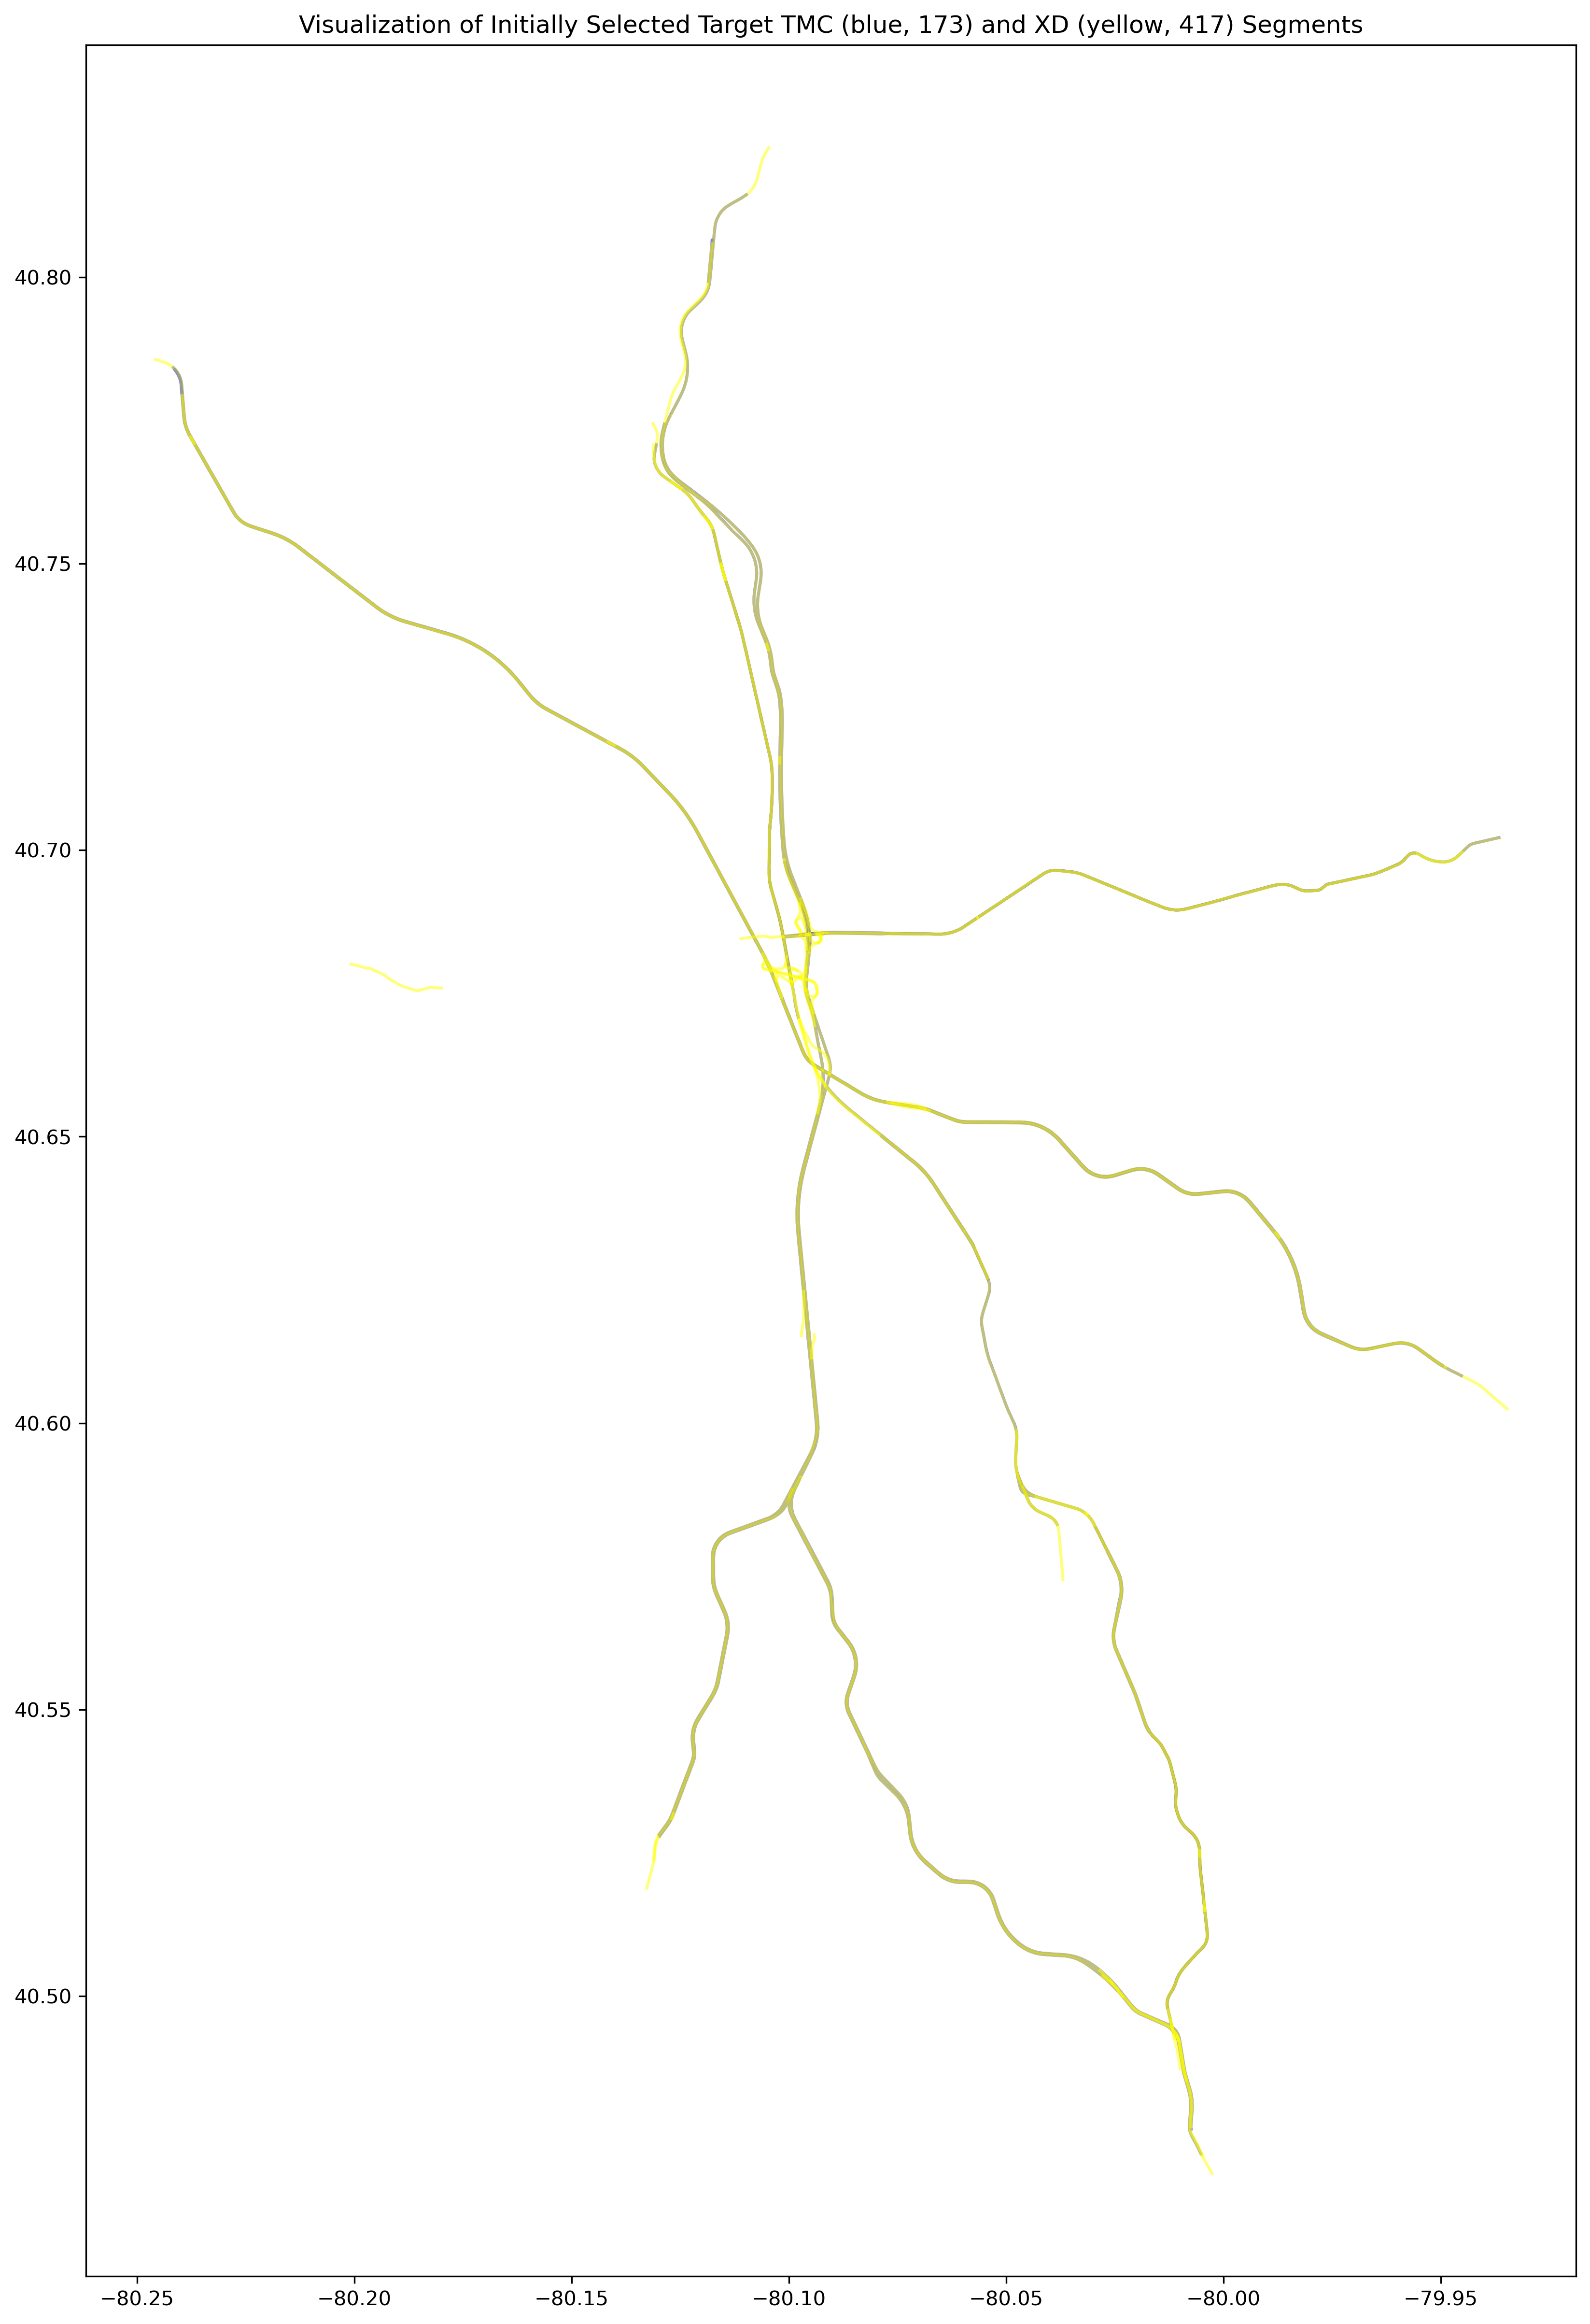

In [48]:
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of Initially Selected Target TMC (blue, 173) and XD (yellow, 417) Segments")
gdf_tmc[gdf_tmc.id_tmc.isin(set_target_tmc)].plot(ax=ax, color="blue", alpha=0.5)
gdf_xd[gdf_xd.id_xd_str.isin(set_target_xd_str)].plot(ax=ax,color="yellow", alpha=0.5)

### [Note] Some observations and Finalized set_target_tmc & set_target_xd_str

#### Observation 1. set_target_tmc contains 173 tmc segments, which corresponds to 366 XD segments, where 355 are covered in currently selected set_target_xd_str (that contains 417 XD segments as of now)

In [27]:
set_target_tmc_to_xd_str =  set(df_tmc_xd_join[df_tmc_xd_join.id_tmc.isin(set_target_tmc)].id_xd_str.unique())  # 366 XD segments

In [28]:
len(set_target_xd_str.intersection(set_target_tmc_to_xd_str))  # 355 XD segments, 277 are covered in XD speed data, the remaining 78 can be imputed by TMC segments

355

#### Observation 2. Those 355 XD segments correspond to 185 TMC segments, which covers the entire set_target_tmc

In [29]:
set_target_tmc_to_xd_str_to_tmc = set(df_tmc_xd_join[df_tmc_xd_join.id_xd_str.isin(set_target_xd_str.intersection(set_target_tmc_to_xd_str))].id_tmc.unique()) # 185 TMC segments

In [30]:
set_target_tmc_to_xd_str_to_tmc.issuperset(set_target_tmc)

True

#### Summary of Observations
- Although we lack data of 11 XD segments (366-355=11), those 355 XD segments still fulfill the correspondance to 173 TMC target segments. In fact, they correspond to 185 TMC segments. 
- Therefore, I will treat 355 XD segments as the FINALIZED target XD segments, and I will convert their features from 355-dimension to 173-dimension through TMC-XD correspondence.

In [31]:
set_target_xd_str = set_target_xd_str.intersection(set_target_tmc_to_xd_str) # finalized 355 XD target segments

In [32]:
set_target_tmc_to_xd_str.difference(set_target_xd_str)

{'1310252437',
 '1310275424',
 '1310352790',
 '1310427861',
 '1310427874',
 '1310563997',
 '1310574747',
 '134198813',
 '134625815',
 '389134964',
 '429088785'}

<AxesSubplot: title={'center': 'Visualization of Eventually Selected Target TMC (blue, 173) and XD (yellow, 355) Segments'}>

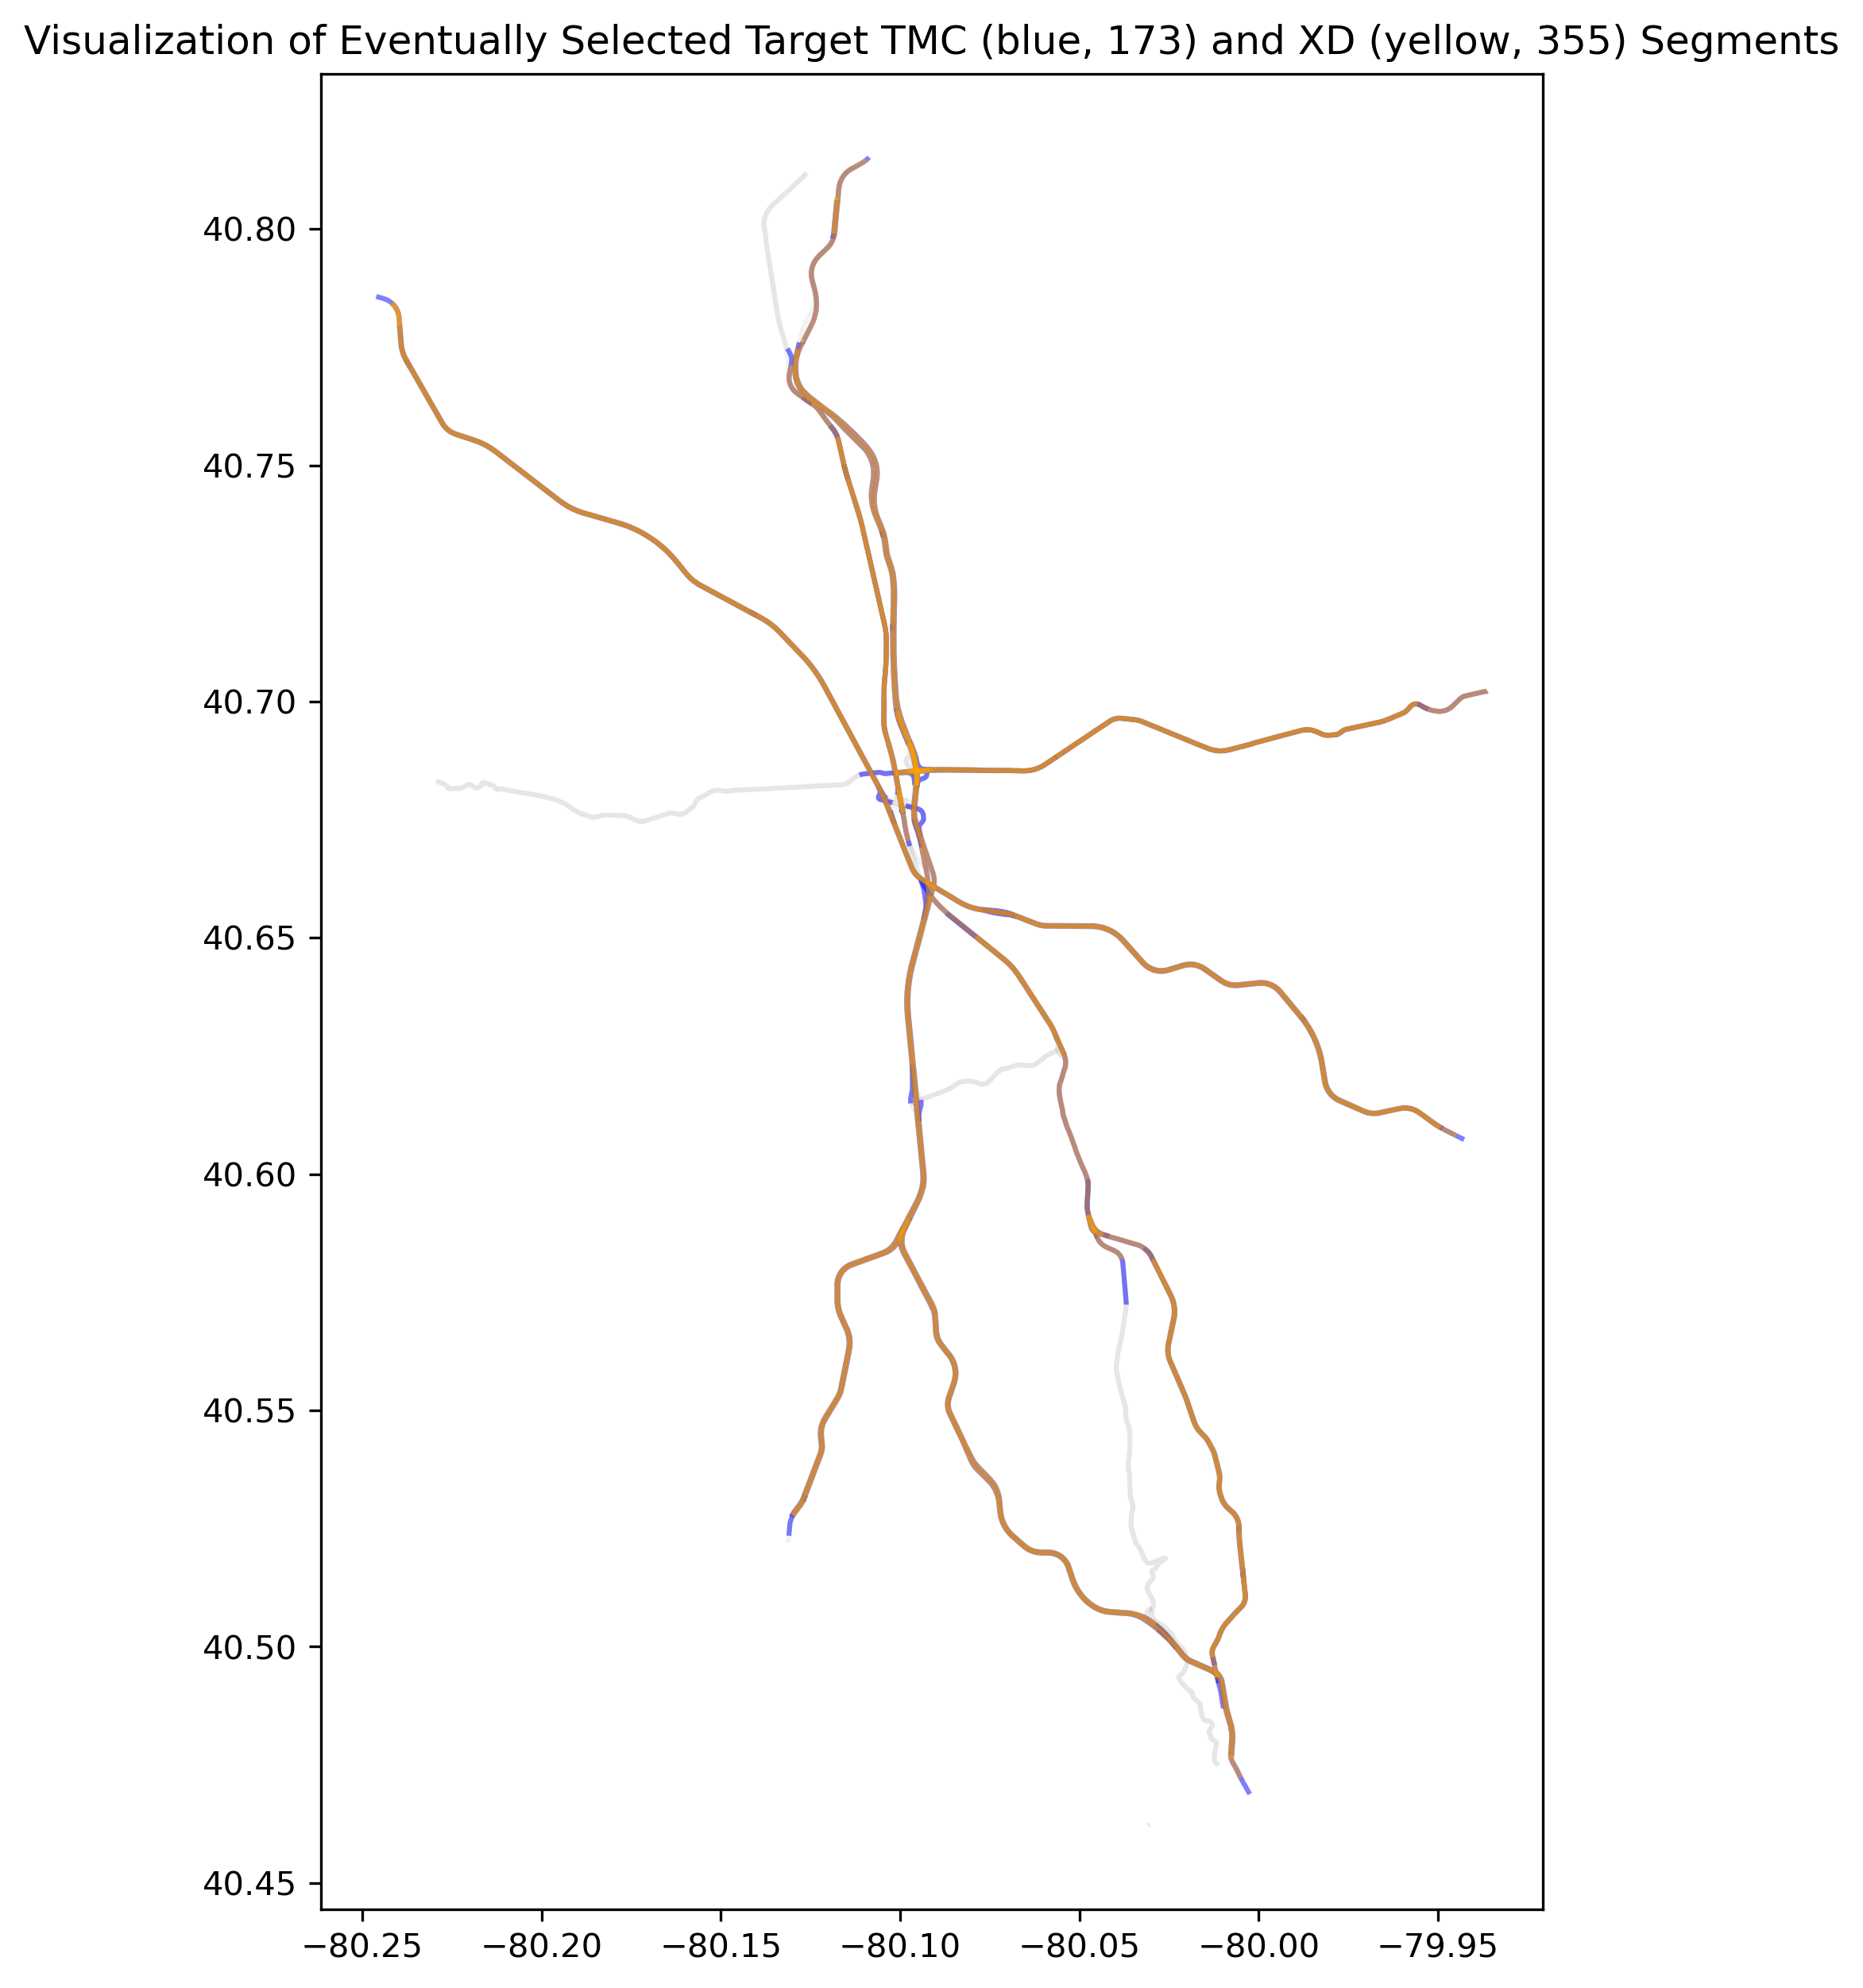

In [34]:
# fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
fig, ax = plt.subplots(1,figsize=(15,10), dpi=300)
ax.set_title("Visualization of Eventually Selected Target TMC (blue, 173) and XD (yellow, 355) Segments")
gdf_tmc.plot(ax=ax, color="grey", alpha=0.1) # TMC segments in cranberry (we only have id & geometry)
gdf_xd[gdf_xd.id_xd_str.isin(set_target_xd_str)].plot(ax=ax,color="blue", alpha=0.5)  # 355 finalized XD target segments
gdf_tmc[gdf_tmc.id_tmc.isin(set_target_tmc)].plot(ax=ax, color="orange", alpha=0.5)  # 173 fianlized TMC target segments
# gdf_xd[gdf_xd.id_xd_str.isin(set_target_tmc_to_xd_str.difference(set_target_xd_str))].plot(ax=ax,color="red", alpha=0.3)  # 11 missing XD segments to completely cover 173 TMC segments

In [58]:
list_target_xd_str = list(set_target_xd_str)
list_target_tmc = list(set_target_tmc)

## Part 3. Processing of Input Features and Output Ground Truth
1. Raw Speed (Imputation)
2. Speed Features
    - Time of Travel Index (TTI)
    - Slowdown Speed (SD)
4. Incident
5. Density
5. Miscellaneous
    - Weather & Time
    - Generation of Final Input Features & Output Ground Truth

### 3.1 Imputation on Raw Speed

#### 3.1.1 TMC Raw Speed

171 out of 173 are collected, missing '104+04439', '104P04438'

Note - Here I just extract speed data during 05:30:00~20:55:00. In the sections afterwards, I will extract input feature (05:30:00~20:25:00) and output ground truth (06:00:00~20:55:00)

In [59]:
# 1. Speed of All Vehicles
# select 173 tmc segments based on all tmc input segments (currently we only get 171)
df_spd_tmc_all = df_spd_tmc_all_1189.loc[:, [c for c in df_spd_tmc_all_1189.columns if c in set_target_tmc]]  # 171 segments, shape (21762, 171), 801947 NaN

In [61]:
# 2. Speed of Trucks
df_spd_tmc_truck = df_raw_spd_tmc_truck.loc[:, ["tmc_code", "measurement_tstamp", "speed"]]
df_spd_tmc_truck = df_spd_tmc_truck.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed")

# select 173 tmc segments based on all tmc input segments (currently we only get 171)
df_spd_tmc_truck = df_spd_tmc_truck.loc[:, [c for c in df_spd_tmc_truck.columns if c in set_target_tmc]]  # 173 segments, shape (59770, 171)

# convert index to datetime object, and select 21762 rows of interest => shape (21762, 171)
df_spd_tmc_truck.index = pd.to_datetime(df_spd_tmc_truck.index)
df_spd_tmc_truck = df_spd_tmc_truck.resample("5 min").asfreq()  # upsampling with 5-min frequency (otherwise, there will be 122 time slots missing)
df_spd_tmc_truck = df_spd_tmc_truck[pd.Index(df_spd_tmc_truck.index.date).isin(busi_date)]
df_spd_tmc_truck = df_spd_tmc_truck[(df_spd_tmc_truck.index.hour * 60 + df_spd_tmc_truck.index.minute >= 330 ) & (df_spd_tmc_truck.index.hour * 60 + df_spd_tmc_truck.index.minute <= 1255)] # (117 * 186, 171), 2190628 NaN

In [63]:
# 3. Speed of Personal Vehicle (PV)
df_spd_tmc_pv = df_raw_spd_tmc_pv.loc[:, ["tmc_code", "measurement_tstamp", "speed"]]
df_spd_tmc_pv = df_spd_tmc_pv.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed")

# select 173 tmc segments based on all tmc input segments (currently we only get 171)
df_spd_tmc_pv = df_spd_tmc_pv.loc[:, [c for c in df_spd_tmc_pv.columns if c in set_target_tmc]]  # 171 segments, shape (59892, 171)

# convert index to datetime object, and select 21762 rows of interest
df_spd_tmc_pv.index = pd.to_datetime(df_spd_tmc_pv.index)
df_spd_tmc_pv = df_spd_tmc_pv[pd.Index(df_spd_tmc_pv.index.date).isin(busi_date)]
df_spd_tmc_pv = df_spd_tmc_pv[(df_spd_tmc_pv.index.hour * 60 + df_spd_tmc_pv.index.minute >= 330 ) & (df_spd_tmc_pv.index.hour * 60 + df_spd_tmc_pv.index.minute <= 1255)]  # (117 * 186, 171), 993997 NaN

#### 3.1.2 XD Raw Speed

In [65]:
# select 355 tmc segments based on all XD input segments (currently we only get 171)
df_spd_xd_1min = df_spd_xd_1min_337.loc[:, [c for c in df_spd_xd_1min_337.columns if c in set_target_xd_str]]  # shape (108810, 277), 653747 NaN
df_spd_xd_5min = df_spd_xd_5min_337.loc[:, [c for c in df_spd_xd_5min_337.columns if c in set_target_xd_str]]  # shape (21762, 277), 4810 NaN

#### 3.1.3 Imputation on TMC Speed

In [69]:
# Step 1. Impute TMC speed (All) on segments '104+04439' and '104P04438' based on XD data (unaugmented, all are real speed data) => shape (21762, 173), 801983 NaN
for tmc in tqdm(list(set(set_target_tmc).difference(df_spd_tmc_all.columns))):
    df_spd_tmc_all[tmc] = df_spd_xd_5min_337[list(df_tmc_xd_join[df_tmc_xd_join.id_tmc == tmc].id_xd_str)].mean(axis=1)
    df_spd_tmc_pv[tmc] = df_spd_tmc_all[tmc]/2.0  # => 994033 NaN
    df_spd_tmc_truck[tmc] = df_spd_tmc_all[tmc]/2.0  # => 2190664 NaN

100%|██████████| 2/2 [00:00<00:00, 264.79it/s]


In [73]:
# Step 2. Impute TMC speed internally (all, pv, truck)
df_spd_tmc_all = df_spd_tmc_all.fillna(df_spd_tmc_pv+df_spd_tmc_truck)  # 801983 NaN
df_spd_tmc_pv = df_spd_tmc_pv.fillna(df_spd_tmc_all-df_spd_tmc_truck)  # 801983 NaN
df_spd_tmc_truck = df_spd_tmc_truck.fillna(df_spd_tmc_all-df_spd_tmc_pv)  # 801983 NaN


In [77]:
# Step 3. Impute TMC speed (All) on all segments based on XD data (unaugmented, all are real data) => shape (21762, 173), 62762 NaN 
count = 0
for tmc in tqdm(df_spd_tmc_all.columns):
    # Since df_spd_xd_5min here is not augmented yet and only covers 337 XD segments, right now there are 10 TMC segments that don't have any corresponding XD in df_spd_xd_5min.
    corresponding_xd = [xd for xd in df_spd_xd_5min_337.columns if xd in list(df_tmc_xd_join[df_tmc_xd_join.id_tmc == tmc].id_xd_str)] 
    if len(corresponding_xd) == 0:
        count += 1
        continue
    df_spd_tmc_all[tmc] = df_spd_tmc_all[tmc].fillna(df_spd_xd_5min_337[corresponding_xd].mean(axis=1))

100%|██████████| 173/173 [00:06<00:00, 24.85it/s]


In [81]:
ratio_pv_vs_all = (df_spd_tmc_pv/df_spd_tmc_all).stack().dropna().mean() # 0.9410401771588854
ratio_truck_vs_all = (df_spd_tmc_truck/df_spd_tmc_all).stack().dropna().mean()  # 0.5147833424299074
ratio_pv_vs_all = ratio_pv_vs_all/(0.5147833424299074 + 0.9410401771588854)  # 0.6463971521937553
ratio_truck_vs_all = ratio_truck_vs_all/(0.5147833424299074 + 0.9410401771588854)  # 0.3536028478062447

In [87]:
# Step 4. Impute with latest observations
df_spd_tmc_all = df_spd_tmc_all.fillna(method='ffill')  # 34 NaN
df_spd_tmc_all = df_spd_tmc_all.fillna(method='bfill')  # 0 NaN

df_spd_tmc_pv = df_spd_tmc_pv.fillna(ratio_pv_vs_all * df_spd_tmc_all)  # 0 NaN
df_spd_tmc_truck = df_spd_tmc_truck.fillna(ratio_truck_vs_all * df_spd_tmc_all)  # 0 NaN

#### 3.1.4 Imputation on XD Speed

In [91]:
# speed data of all tmc segments that will be used to impute XD speed
df_spd_tmc_all_1191 = pd.concat([df_spd_tmc_all_1189, df_spd_tmc_all[['104+04439', '104P04438']]], axis=1)  # (21762, 1191)

In [92]:
# Step 1. Impute XD speed on 78 segments based on TMC data (unaugmented, all are real speed data, except '104+04439', '104P04438') => shape (21762, 355), 414067 NaN
for xd in tqdm(list(set(set_target_xd_str).difference(df_spd_xd_5min.columns))):
    df_spd_xd_5min[xd] = df_spd_tmc_all_1191[list(df_tmc_xd_join[df_tmc_xd_join.id_xd_str == xd].id_tmc)].mean(axis=1)

100%|██████████| 78/78 [00:00<00:00, 538.01it/s]


In [94]:
# Step 2. Impute XD speed on all segments based on TMC data (unaugmented, all are real speed data, except '104+04439', '104P04438') => shape (21762, 355), 410395 NaN
count=0
for xd in tqdm(df_spd_xd_5min.columns):
    # All of the 355 XD segments have some corresponding TMC segments (count=0)
    corresponding_tmc = [tmc for tmc in df_spd_tmc_all_1191.columns if tmc in list(df_tmc_xd_join[df_tmc_xd_join.id_xd_str == xd].id_tmc)] 
    if len(corresponding_tmc)==0:
        count += 1
        continue
    df_spd_xd_5min[xd] = df_spd_xd_5min[xd].fillna(df_spd_tmc_all_1191[corresponding_tmc].mean(axis=1))

100%|██████████| 355/355 [00:48<00:00,  7.34it/s]


In [98]:
# Step 3. Impute with latest observations
df_spd_xd_5min = df_spd_xd_5min.fillna(method='ffill')  # 189 NaN
df_spd_xd_5min = df_spd_xd_5min.fillna(method='bfill')  # 0 NaN

#### 3.1.5 Separate Input & Output and Save Speed Data into Files

In [100]:
df_in_spd_tmc_all = df_spd_tmc_all[(df_spd_tmc_all.index.hour * 60 + df_spd_tmc_all.index.minute >= 330 ) & (df_spd_tmc_all.index.hour * 60 + df_spd_tmc_all.index.minute <= 1225)]  #(21060, 173)
df_in_spd_tmc_pv = df_spd_tmc_pv[(df_spd_tmc_pv.index.hour * 60 + df_spd_tmc_pv.index.minute >= 330 ) & (df_spd_tmc_pv.index.hour * 60 + df_spd_tmc_pv.index.minute <= 1225)]  #(21060, 173)
df_in_spd_tmc_truck = df_spd_tmc_truck[(df_spd_tmc_truck.index.hour * 60 + df_spd_tmc_truck.index.minute >= 330 ) & (df_spd_tmc_truck.index.hour * 60 + df_spd_tmc_truck.index.minute <= 1225)]  #(21060, 173)

In [101]:
df_out_spd_tmc_all = df_spd_tmc_all[(df_spd_tmc_all.index.hour * 60 + df_spd_tmc_all.index.minute >= 360 ) & (df_spd_tmc_all.index.hour * 60 + df_spd_tmc_all.index.minute <= 1255)]  #(21060, 173)
df_out_spd_tmc_pv = df_spd_tmc_pv[(df_spd_tmc_pv.index.hour * 60 + df_spd_tmc_pv.index.minute >= 360 ) & (df_spd_tmc_pv.index.hour * 60 + df_spd_tmc_pv.index.minute <= 1255)]  #(21060, 173)
df_out_spd_tmc_truck = df_spd_tmc_truck[(df_spd_tmc_truck.index.hour * 60 + df_spd_tmc_truck.index.minute >= 360 ) & (df_spd_tmc_truck.index.hour * 60 + df_spd_tmc_truck.index.minute <= 1255)]  #(21060, 173)

In [102]:
df_in_spd_xd_5min = df_spd_xd_5min[(df_spd_xd_5min.index.hour * 60 + df_spd_xd_5min.index.minute >= 330 ) & (df_spd_xd_5min.index.hour * 60 + df_spd_xd_5min.index.minute <= 1225)]
df_out_spd_xd_5min = df_spd_xd_5min[(df_spd_xd_5min.index.hour * 60 + df_spd_xd_5min.index.minute >= 360 ) & (df_spd_xd_5min.index.hour * 60 + df_spd_xd_5min.index.minute <= 1255)]

In [103]:
# Save speed data (both input and output)
pickle.dump(df_spd_xd_5min, open("../data/df_spd_xd_5min.pkl", "wb"))
pickle.dump(df_spd_xd_1min, open("../data/df_spd_xd_1min.pkl", "wb"))

pickle.dump(df_spd_tmc_all, open("../data/df_spd_tmc_all.pkl", "wb"))
pickle.dump(df_spd_tmc_pv, open("../data/df_spd_tmc_pv.pkl", "wb"))
pickle.dump(df_spd_tmc_truck, open("../data/df_spd_tmc_truck.pkl", "wb"))

### 3.2 Speed Features

#### 3.2.1 Time of Travel Index (TTI)

In [104]:
# 1. TMC
df_in_tti_tmc = df_spd_tmc_all.quantile(q=0.85, axis=0)/df_spd_tmc_all
df_in_tti_tmc = df_in_tti_tmc[(df_in_tti_tmc.index.hour * 60+ df_in_tti_tmc.index.minute >= 330 ) & (df_in_tti_tmc.index.hour * 60 + df_in_tti_tmc.index.minute <= 1225)] 
df_in_tti_tmc = df_in_tti_tmc.where(df_in_tti_tmc>1.0, 1.0) # (21060, 173)

In [105]:
# 2. XD
df_in_tti_xd_5min = df_spd_xd_5min.quantile(q=0.85, axis=0)/df_spd_xd_5min
df_in_tti_xd_5min = df_in_tti_xd_5min[(df_in_tti_xd_5min.index.hour * 60+ df_in_tti_xd_5min.index.minute >= 330 ) & (df_in_tti_xd_5min.index.hour * 60 + df_in_tti_xd_5min.index.minute <= 1225)] 
df_in_tti_xd_5min = df_in_tti_xd_5min.where(df_in_tti_xd_5min>1.0, 1.0) # (21060, 355)

#### 3.2.2 Slowdown Speed (SD)

In [108]:
# 1. TMC
df_avg_upstream_spd_tmc = pd.DataFrame()  # avg upstream data for each target TMC segments

In [109]:
# Step 1. Collect speed data of all target tmc segments & their upstream segments, shape (21762, 1192)
df_spd_tmc_with_upstream_all = df_spd_tmc_all_1191.copy()  

for tmc in tqdm(list_target_tmc):
    # For target tmc segments, fill NaN with df_spd_tmc_all
    df_spd_tmc_with_upstream_all[tmc] = df_spd_tmc_with_upstream_all[tmc].fillna(df_spd_tmc_all[tmc])

    upstream = list(dict_upstream_unique_tmc[tmc].difference(df_spd_tmc_with_upstream_all.columns))
    for u in upstream:
        # Speed data of some upstream tmc segments are not covered in df_spd_tmc_all. We need to infer from corresponding XD data
        corresponding_xd = [xd for xd in df_spd_xd_5min.columns if xd in list(df_tmc_xd_join[df_tmc_xd_join.id_tmc == u].id_xd_str)] 
        if len(corresponding_xd) == 0:
            continue
        if u in df_spd_tmc_with_upstream_all.columns:
            df_spd_tmc_with_upstream_all[u] = df_spd_tmc_with_upstream_all[u].fillna(df_spd_xd_5min[corresponding_xd].mean(axis=1))
        else:
            df_spd_tmc_with_upstream_all[u] = df_spd_xd_5min[corresponding_xd].mean(axis=1)

100%|██████████| 173/173 [00:05<00:00, 31.02it/s]


In [110]:
# Step 2. Compute avg upstream data for all target TMC segments

count = 0
for tmc in tqdm(list_target_tmc):
    # All tmc have their avg upstream speed computed. 
    upstream_tmc = list(dict_upstream_unique_tmc[tmc].intersection(df_spd_tmc_with_upstream_all.columns))
    if len(upstream_tmc) == 0:
        count += 1
    df_avg_upstream_spd_tmc[tmc] = df_spd_tmc_with_upstream_all[upstream_tmc].mean(axis=1)
    

 10%|█         | 18/173 [00:00<00:00, 179.23it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/451593548.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_tmc[tmc] = df_spd_tmc_with_upstream_all[upstream_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/451593548.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_tmc[tmc] = df_spd_tmc_with_upstream_all[upstream_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykerne

In [114]:
# Step 3. Fill NaN in avg upstream data for all target TMC segments
# shape (21762, 173), 74388 NaN
df_avg_upstream_spd_tmc = df_avg_upstream_spd_tmc.fillna(method="ffill") # 29 NaN
df_avg_upstream_spd_tmc = df_avg_upstream_spd_tmc.fillna(method="bfill") # 0 NaN

In [116]:
# Step 4. Compute Slowdown Speed of all target TMC segments
df_in_sd_tmc = df_avg_upstream_spd_tmc-df_spd_tmc_all
df_in_sd_tmc = df_in_sd_tmc.where(df_in_sd_tmc>0, 0.0)
df_in_sd_tmc = df_in_sd_tmc[(df_in_sd_tmc.index.hour * 60+ df_in_sd_tmc.index.minute >= 330 ) & (df_in_sd_tmc.index.hour * 60 + df_in_sd_tmc.index.minute <= 1225)] 

In [117]:
# 2. XD
df_avg_upstream_spd_xd = pd.DataFrame()  # avg upstream data for each target XD segments

In [118]:
# Step 1. Collect speed data of all target XD segments & their upstream segments, shape (21762, 438)
df_spd_xd_with_upstream = df_spd_xd_5min_337.copy()  

for xd in tqdm(list_target_xd_str):
    # For target xd segments, fill NaN with df_spd_xd_5min
    if xd in df_spd_xd_with_upstream.columns:
        df_spd_xd_with_upstream[xd] = df_spd_xd_with_upstream[xd].fillna(df_spd_xd_5min[xd])
    else:
        df_spd_xd_with_upstream[xd] = df_spd_xd_5min[xd]

    upstream = list(dict_upstream_unique_xd_str[xd].difference(df_spd_xd_with_upstream.columns))
    for u in upstream:
        # Speed data of some upstream xd segments are not covered in df_spd_xd_5min. We need to infer from corresponding TMC data
        corresponding_tmc = [tmc for tmc in df_spd_tmc_with_upstream_all.columns if tmc in list(df_tmc_xd_join[df_tmc_xd_join.id_xd_str == u].id_tmc)] 
        if len(corresponding_tmc) == 0:
            continue
        if u in df_spd_xd_with_upstream.columns:
            df_spd_xd_with_upstream[u] = df_spd_xd_with_upstream[u].fillna(df_spd_tmc_with_upstream_all[corresponding_tmc].mean(axis=1))
        else:
            df_spd_xd_with_upstream[u] = df_spd_tmc_with_upstream_all[corresponding_tmc].mean(axis=1)

 12%|█▏        | 41/355 [00:14<00:49,  6.32it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/1483326659.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_spd_xd_with_upstream[u] = df_spd_tmc_with_upstream_all[corresponding_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/1483326659.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_spd_xd_with_upstream[u] = df_spd_tmc_with_upstream_all[corresponding_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T

In [119]:
# Step 2. Compute avg upstream data for all target XD segments
 
count = 0
for xd in tqdm(list_target_xd_str):
    # All xd has their avg upstream speed computed. 
    upstream_xd = list(dict_upstream_unique_xd_str[xd].intersection(df_spd_xd_with_upstream.columns))
    if len(upstream_xd) == 0:
        count += 1
    df_avg_upstream_spd_xd[xd] = df_spd_xd_with_upstream[upstream_xd].mean(axis=1)
    

 26%|██▌       | 92/355 [00:00<00:01, 226.21it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/2785652676.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_xd[xd] = df_spd_xd_with_upstream[upstream_xd].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/2785652676.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_xd[xd] = df_spd_xd_with_upstream[upstream_xd].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/278565

In [126]:
# Step 3. Fill NaN in avg upstream data for all target XD segments
# shape (21762, 355), 16659 NaN
df_avg_upstream_spd_xd = df_avg_upstream_spd_xd.fillna(method="ffill") # 7 NaN
df_avg_upstream_spd_xd = df_avg_upstream_spd_xd.fillna(method="bfill") # 0 NaN

In [128]:
# Step 4. Compute slowdown speed for all target XD segments
df_in_sd_xd = df_avg_upstream_spd_xd-df_spd_xd_5min
df_in_sd_xd = df_in_sd_xd.where(df_in_sd_xd>0, 0.0)
df_in_sd_xd = df_in_sd_xd[(df_in_sd_xd.index.hour * 60+ df_in_sd_xd.index.minute >= 330 ) & (df_in_sd_xd.index.hour * 60 + df_in_sd_xd.index.minute <= 1225)] 

#### 3.2.3 Save Files

In [163]:
# Save speed features 
pickle.dump(df_in_tti_tmc, open("../data/df_in_tti_tmc.pkl", "wb"))
pickle.dump(df_in_sd_tmc, open("../data/df_in_sd_tmc.pkl", "wb"))
pickle.dump(df_in_tti_xd_5min, open("../data/df_in_tti_xd_5min.pkl", "wb"))
pickle.dump(df_in_sd_xd, open("../data/df_in_sd_xd_5min.pkl", "wb"))

### 3.3 Incident Processing

#### 3.3.1 Incident Input Features

##### 3.3.1.1 Load Incident Features from Old X Input (173 tmc segments)

In [129]:
# get indices of old_col that will remain as new columns
col_idx = []  # will store the indices of 194 old columns that will become new_X (173 inc, 21 weather & time)
col_name = []
for i in range(987):
    c = old_col[i]
    if "inc" in c and c[4:] in set_target_tmc:
        col_idx.append(i)
        col_name.append(c[4:])
col_idx += list(range(987, 1008)) # len 194, incident features: 1~173, weather & time: 174~194

In [130]:
np_in_inc = old_X[:, -1, col_idx[:173]].reshape(164, 180, -1) # (164, 180, 194) 164 days (busi + non-busi) * 180 daily time slots (05:30:00 ~ 20:25:00)
np_in_wt = old_X[:, -1, col_idx[173:]].reshape(164, 180, -1) # (164, 180, 194) 164 days (busi + non-busi) * 180 daily time slots (05:30:00 ~ 20:25:00)

# select business dates only
np_in_inc = np_in_inc[busi_idx, :, :].reshape(-1, 173)  # (117*180, 173)
np_in_wt = np_in_wt[busi_idx, :, :].reshape(-1, 21)  # (117*180, 21)

In [131]:
# Convert to DataFrame, with datatime objects as indices
df_in_inc = pd.DataFrame(np_in_inc, columns=col_name)  # (21060, 173)
df_in_inc.index = df_in_spd_tmc_all.index

df_in_wt = pd.DataFrame(np_in_wt) # (21060, 21)
df_in_wt.index = df_in_spd_tmc_all.index

In [132]:
# Sort the order of columns to align with other DataFrame
df_in_inc = df_in_inc[df_in_spd_tmc_all.columns]

##### 3.3.1.2 Mark Segments with Abnormal Speed as in Incident Status

In [133]:
df_in_abn_spd_tmc_all = (df_in_spd_tmc_all<df_in_spd_tmc_all.quantile(q=para_in_inc_spd_quantile_threshold, axis=0)).astype(float)
df_in_inc = df_in_inc.where(df_in_inc >= df_in_abn_spd_tmc_all, df_in_abn_spd_tmc_all)

#### 3.3.2 Output Incident Ground Truth

##### 3.3.2.1 Load Output Incident Data

In [135]:
df_out_inc = pd.read_csv("../data/incident_labels.csv")  # 5-min frequency
df_out_inc = df_out_inc.set_index("measurement_tstamp")
df_out_inc.index = pd.to_datetime(df_out_inc.index)
df_out_inc = df_out_inc[df_out_spd_tmc_all.columns]
df_out_inc = df_out_inc[(pd.Index(df_out_inc.index.date).isin(busi_date)) & (df_out_inc.index.hour*60 + df_out_inc.index.minute >= 360) & (df_out_inc.index.hour*60 + df_out_inc.index.minute < 1260) ]  # shape (21060, 173)

##### 3.3.2.2 Mark Segments with Abnormal Speed as in Incident Status

In [136]:
df_out_abn_spd_tmc_all = (df_out_spd_tmc_all<df_out_spd_tmc_all.quantile(q=para_out_inc_spd_quantile_threshold, axis=0)).astype(float)
df_out_inc = df_out_inc.where(df_out_inc >= df_out_abn_spd_tmc_all, df_out_abn_spd_tmc_all)

##### 3.3.2.3 Mark Appropriate Upstream Segments as in Incident
We define appropriate upstream segments with the following hyper-parameters:
- para_out_inc_space_limit: how far we are tracing upstream (5 miles here)
- para_out_inc_tti_threshold: how slow the speed is compared with its reference speed (1.6 here)
- para_out_inc_lead_time: how long we are marking in advance (30 min here)

In [138]:
df_out_tti_tmc = df_spd_tmc_all.quantile(q=0.85, axis=0)/df_spd_tmc_all
df_out_tti_tmc = df_out_tti_tmc[(df_out_tti_tmc.index.hour * 60+ df_out_tti_tmc.index.minute >= 360 ) & (df_out_tti_tmc.index.hour * 60 + df_out_tti_tmc.index.minute <= 1255)] 
df_out_tti_tmc = df_out_tti_tmc.where(df_out_tti_tmc>1.0, 1.0) # (21060, 179)

In [139]:
for tmc in tqdm(df_out_inc.columns):
    upstream_target = list(dict_upstream_unique_tmc_5_miles[tmc].intersection(set_target_tmc))

    # Compute time slots (incident time + lead time)
    inc_time = list((df_out_inc[[tmc]]>0).index)
    time_slots = set()
    for time in inc_time:
        for t in range(int(para_out_inc_lead_time//5+1)): # lead time
            next_time = time + pd.Timedelta(minutes=5*t)
            if next_time not in time_slots and next_time.date() == time.date() and next_time.hour * 60 + next_time.minute <= 1255:
                time_slots.add(next_time)

    # Compute the dataframe of appropriate upstream segments in corresponding time slots
    df_appro_upstream = (df_out_tti_tmc[df_out_tti_tmc.index.isin(time_slots)][upstream_target] > para_out_inc_tti_threshold).astype(float) 

    # Mark when appropriate
    df_out_inc.loc[time_slots, upstream_target] = df_out_inc[df_out_inc.index.isin(time_slots)][upstream_target].where(df_out_inc[df_out_inc.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)



  0%|          | 0/173 [00:00<?, ?it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/1050186169.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_inc.loc[time_slots, upstream_target] = df_out_inc[df_out_inc.index.isin(time_slots)][upstream_target].where(df_out_inc[df_out_inc.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)
  1%|          | 1/173 [00:00<01:34,  1.82it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_52156/1050186169.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_inc.loc[time_slots, upstream_target] = df_out_inc[df_out_inc.index.isin(time_slots)][upstream_target].where(df_out_inc[df_out_inc.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)
  1%|          | 2/173 [00:01<01:40,  1.71it/s]/var/folders/y2/1kk0np3x01qchz21p

#### 3.3.3 Save Files

In [166]:
# Save speed features 
pickle.dump(df_in_inc, open("../data/df_in_inc.pkl", "wb"))
pickle.dump(df_out_inc, open("../data/df_out_inc.pkl", "wb"))

# Save weather & time features
pickle.dump(df_in_wt, open("../data/df_in_wt.pkl", "wb"))

### 3.4 Density Processing

#### 3.4.1 Load TMC Density (using TMC all)

In [141]:
# select columns based on target tmc segments, 171 out of 173 are collected, missing '104+04439', '104P04438'
df_in_dens_tmc = df_dens_tmc_all_1189.loc[:, [c for c in df_dens_tmc_all_1189.columns if c in set_target_tmc]] 
df_in_dens_tmc = df_in_dens_tmc[(df_in_dens_tmc.index.hour * 60 + df_in_dens_tmc.index.minute >= 330 ) & (df_in_dens_tmc.index.hour * 60 + df_in_dens_tmc.index.minute <= 1225)]  # (117 * 180, 171), 752490 NaN

#### 3.4.2 Load XD Density

In [143]:
# select columns based on target tmc segments, 277 out of 355 are collected, missing 78 segments
df_in_dens_xd_1min = df_dens_xd_1min_337.loc[:, [c for c in df_dens_xd_1min_337.columns if c in set_target_tmc_to_xd_str]]   
df_in_dens_xd_1min = df_in_dens_xd_1min[(df_in_dens_xd_1min.index.hour * 60 + df_in_dens_xd_1min.index.minute >= 330 ) & (df_in_dens_xd_1min.index.hour * 60 + df_in_dens_xd_1min.index.minute <= 1225)]  # (104832, 277), 632175 NaN
df_in_dens_xd_5min = df_dens_xd_5min_337.loc[:, [c for c in df_dens_xd_5min_337.columns if c in set_target_tmc_to_xd_str]]  
df_in_dens_xd_5min = df_in_dens_xd_5min[(df_in_dens_xd_5min.index.hour * 60 + df_in_dens_xd_5min.index.minute >= 330 ) & (df_in_dens_xd_5min.index.hour * 60 + df_in_dens_xd_5min.index.minute <= 1225)]   # (21060, 277), 4582 NaN

#### 3.4.3 Impute TMC Density

In [146]:
# Step 1. Impute TMC density (All) on segments '104+04439' and '104P04438' based on XD data (unaugmented, all are real density data) => shape (21060, 173), 752526 NaN
for tmc in tqdm(list(set(set_target_tmc).difference(df_in_dens_tmc.columns))):
    df_in_dens_tmc[tmc] = df_dens_xd_5min_337[list(df_tmc_xd_join[df_tmc_xd_join.id_tmc == tmc].id_xd_str)].mean(axis=1)

100%|██████████| 2/2 [00:00<00:00, 469.29it/s]


In [148]:
# Step 2. Impute TMC density (All) on all segments based on XD data (unaugmented, all are real data) => shape (21060, 173), 58965 NaN 
count = 0
for tmc in tqdm(df_in_dens_tmc.columns):
    # Since df_dens_xd_5min_337 here is not augmented yet and only covers 337 XD segments, so right now there are 10 TMC segments that don't have corresponding XD in df_dens_xd_5min_337.
    corresponding_xd = [xd for xd in df_dens_xd_5min_337.columns if xd in list(df_tmc_xd_join[df_tmc_xd_join.id_tmc == tmc].id_xd_str)] 
    if len(corresponding_xd) == 0:
        count += 1
        continue
    df_in_dens_tmc[tmc] = df_in_dens_tmc[tmc].fillna(df_dens_xd_5min_337[corresponding_xd].mean(axis=1))

100%|██████████| 173/173 [00:07<00:00, 24.61it/s]


In [150]:
# Step 3. Impute with Lowest Value (1/6 <=> "A", which denotes "fewer than five values")
df_in_dens_tmc = df_in_dens_tmc.fillna(1/6)    # 0 NaN

#### 3.4.4 Impute XD Density

In [152]:
# density data of all TMC segments used to impute XD data
df_in_dens_tmc_all_1189 = df_dens_tmc_all_1189[(df_dens_tmc_all_1189.index.hour * 60 + df_dens_tmc_all_1189.index.minute >= 330 ) & (df_dens_tmc_all_1189.index.hour * 60 + df_dens_tmc_all_1189.index.minute <= 1225)] 
df_in_dens_tmc_all_1191 = pd.concat([df_in_dens_tmc_all_1189, df_in_dens_tmc[['104+04439', '104P04438']]], axis=1)  # (21060, 1191), 12925281 NaN

In [153]:
# Step 1. Impute XD density on 78 segments based on TMC data (unaugmented, all are real density data, except '104+04439', '104P04438') => shape (21060, 355), 387169 NaN
for xd in tqdm(list(set(set_target_xd_str).difference(df_in_dens_xd_5min.columns))):
    df_in_dens_xd_5min[xd] = df_in_dens_tmc_all_1191[list(df_tmc_xd_join[df_tmc_xd_join.id_xd_str == xd].id_tmc)].mean(axis=1)

100%|██████████| 78/78 [00:00<00:00, 511.10it/s]


In [155]:
# Step 2. Impute XD density on all segments based on TMC data (unaugmented, all are real density data, except '104+04439', '104P04438') => shape (21762, 355), 383602 NaN
count=0
for xd in tqdm(df_in_dens_xd_5min.columns):
    # All of the 355 XD segments have some corresponding TMC segments (count=0)
    corresponding_tmc = [tmc for tmc in df_in_dens_tmc_all_1191.columns if tmc in list(df_tmc_xd_join[df_tmc_xd_join.id_xd_str == xd].id_tmc)] 
    if len(corresponding_tmc)==0:
        count += 1
        continue
    df_in_dens_xd_5min[xd] = df_in_dens_xd_5min[xd].fillna(df_in_dens_tmc_all_1191[corresponding_tmc].mean(axis=1))

100%|██████████| 355/355 [00:49<00:00,  7.19it/s]


In [157]:
# Step 3. Impute with Lowest Value (1/6 <=> "A", which denotes "fewer than five values")
df_in_dens_xd_5min = df_in_dens_xd_5min.fillna(1/6)   # 0 NaN

#### 3.4.5 Save Files

In [165]:
# Save speed features 
pickle.dump(df_in_dens_tmc, open("../data/df_in_dens_tmc.pkl", "wb"))
pickle.dump(df_in_dens_xd_5min, open("../data/df_in_dens_xd_5min.pkl", "wb"))

### 3.5 Generate Final Input and Output

#### 3.5.1 Merge Features into Input

In [159]:
# (21060, 2652) 
# second dimension: 
#       528 density (173 tmc + 355 xd)
#       874 raw speed (173 tmc spd all, 173 tmc spd truck, 173 tmc spd pv, 355 xd spd) 
#       528 tti (173 tmc + 355 xd)
#       528 sd (173 tmc + 355 xd)
#       173 inc (tmc)
#       21 weather & time
list_df_in = [df_in_dens_tmc, df_in_dens_xd_5min, df_in_spd_tmc_all, df_in_spd_tmc_truck, df_in_spd_tmc_pv, df_in_spd_xd_5min, df_in_tti_tmc, df_in_tti_xd_5min, df_in_sd_tmc, df_in_sd_xd, df_in_inc, df_in_wt]
np_in = np.concatenate([df.to_numpy() for df in list_df_in], axis=1) 

In [160]:
# Scaling Normalization (min-max normalization)
scaler = MinMaxScaler()
np_in = scaler.fit_transform(np_in)

In [162]:
np.save("../data/np_in.npy", np_in)

#### 3.5.2 Merge Ground Truth Data into Output

In [170]:
np_out_xd_5min = df_out_spd_xd_5min.to_numpy()  # (21060, 355)
list_df_out_tmc = [df_out_spd_tmc_all, df_out_spd_tmc_truck, df_out_spd_tmc_pv, df_out_inc]
np_out_tmc = np.concatenate(list_df_out_tmc, axis=1)  # (21060, 173*4)

In [173]:
np.save("../data/np_out_xd_5min.npy", np_out_xd_5min)
np.save("../data/np_out_tmc.npy", np_out_tmc)

In [174]:
# save column names for visualization of model inference results
pickle.dump(list(df_in_dens_tmc.columns), open("../data/columns_tmc.pkl", "wb"))
pickle.dump(list(df_in_dens_xd_5min.columns), open("../data/columns_xd.pkl", "wb"))

## Part 4 Waze DataFrame

Generate Waze report dataframe for segments selected for output. The dataframe will be used to measure timeliness of incident status prediction by our 2-stage model.

In [183]:
pd.read_pickle("../data/waze_df.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '../data/waze_df.pickle'

In [180]:
'''
size (47520, 315)
47520: 165 days (2019.2.10 ~ 2019.7.24) * 24 hrs * 12 slots/hr
'''
df_waze = pd.read_pickle("../data/waze_df.pickle")
df_waze = df_waze[set_target_tmc]
df_waze = df_waze[
            (pd.Index(df_waze.index.date).isin(busi_date)) & 
            (df_waze.index.hour*60 + df_waze.index.minute >= 360) & 
            (df_waze.index.hour*60 + df_waze.index.minute < 1260)
            ] 

FileNotFoundError: [Errno 2] No such file or directory: '../data/waze_df.pickle'

In [56]:
waze_out = waze_df[new_out_tmc.union(new_out_xd)]
waze_out_5_min = waze_out[
            (pd.Index(waze_out.index.date).isin(busi_date)) & 
            (waze_out.index.hour*60 + waze_out.index.minute >= 360) & 
            (waze_out.index.hour*60 + waze_out.index.minute < 1260)
            ]  # (21060, 75), with same segment order as new_Y_tmc and new_Y_xd

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_6888/2191235339.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  waze_out = waze_df[new_out_tmc.union(new_out_xd)]


In [57]:
waze_out_5_min

,104+04736,104N04441,104P06676,104-04442,104P04441,104-04742,1310597255,104P04444,104+06681,1310330692,...,1310427817,104-04739,104+06678,104-04542,104+06680,104-06680,1310457035,104N04442,104-11466,104-04444
2019-02-11 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-11 06:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-11 06:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-11 06:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-11 06:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 20:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 20:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 20:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
np.save("../data/waze_out_5_min_v3.npy", waze_out_5_min.to_numpy())